In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [19]:
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct)

In [20]:
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

In [21]:
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

In [22]:
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

In [23]:
input_train = input_data[index_train, :]
correct_train = correct_data[index_train, :]
input_test = input_data[index_test, :]
correct_test = correct_data[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

In [24]:
n_in = 4
n_mid = 25
n_out = 3

wb_width = 0.1
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100

In [25]:
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros((n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
    
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w

        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b

In [26]:
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)

    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis = 0)

        self.grad_x = np.dot(delta, self.w.T)

In [27]:
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b

        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)

    def backward(self, t):
        delta = self.y -t

        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)

        self.grad_x = np.dot(delta, self.w.T)

In [28]:
middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid, n_out)

In [29]:
def forward_propagation(x):
    middle_layer_1.forward(x)
    middle_layer_2.forward(middle_layer_1.y)
    output_layer.forward(middle_layer_2.y)

def backpropagation(t):
    output_layer.backward(t)
    middle_layer_2.backward(output_layer.grad_x)
    middle_layer_1.backward(middle_layer_2.grad_x)

In [30]:
def uppdate_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)

def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

In [31]:
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

In [32]:
n_batch = n_train // batch_size
for i in range(epoch):

    forward_propagation(input_train)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test)
    error_test = get_error(correct_test, n_test)

    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)

    if i%interval == 0:
        print("Epoch: " + str(i) + "/" + str(epoch),
              "Error:_train: " + str(error_train),
              "Error_test: " + str(error_test))
        
    index_random = np.arange(n_train)
    np.random.shuffle(index_random)

    for j in range(n_batch):

        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)

        uppdate_wb()

Epoch: 0/1000 Error:_train: 1.0946339573644082 Error_test: 1.092931695264936
Epoch: 100/1000 Error:_train: 0.04243833835831627 Error_test: 0.08072215946211125


Epoch: 200/1000 Error:_train: 0.024250234349889706 Error_test: 0.07193792697765095
Epoch: 300/1000 Error:_train: 0.017237748797288753 Error_test: 0.07211810140909002
Epoch: 400/1000 Error:_train: 0.013120330639099887 Error_test: 0.07428627063439831
Epoch: 500/1000 Error:_train: 0.010437593541327362 Error_test: 0.07725736520956021
Epoch: 600/1000 Error:_train: 0.008483525495697372 Error_test: 0.07936542556316395
Epoch: 700/1000 Error:_train: 0.00709249670604974 Error_test: 0.08121131948506215
Epoch: 800/1000 Error:_train: 0.005986929674969962 Error_test: 0.08354529608603324
Epoch: 900/1000 Error:_train: 0.005156716124477759 Error_test: 0.08559545913682731


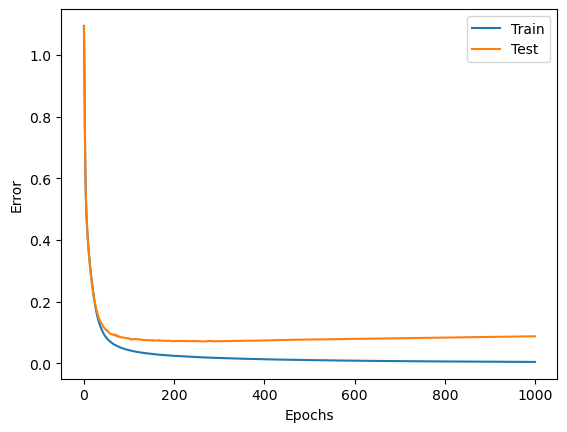

In [33]:
plt.plot(train_error_x, train_error_y, label = "Train")
plt.plot(test_error_x, test_error_y, label = "Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [34]:
forward_propagation(input_train)
count_train = np.sum(np.argmax(output_layer.y,
                               axis=1) == np.argmax(correct_train, axis=1))

forward_propagation(input_test)
count_test = np.sum(np.argmax(output_layer.y,
                              axis=1) == np.argmax(correct_test, axis=1))

print("Accuracy Train: ", str(count_train/n_train*100) + "%\n"
      "Accuracy Test: ", str(count_test/n_test*100) + "%")

Accuracy Train:  100.0%
Accuracy Test:  94.66666666666667%
